# CoppeliaSim - CalcUABlator

## Import libraries:

In [27]:
import sim
import numpy as np
import cv2                             # opencv
import matplotlib.pyplot as plt        # pyplot
import time
import easyocr
from sympy.physics.mechanics import dynamicsymbols
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex='mathjax', pretty_print=False)
import time
from sympy import *

## Establish the connection:

In [28]:
def connect(port):
# Establishes the connection to COPPELIA
# The port must match the connection port in COPPELIA -- PRESS PLAY in Coppelia Scene!!!
# returns the client number or -1 if the connection cannot be established
    sim.simxFinish(-1) # just in case, close all opened connections
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5) # Conectarse
    if clientID == 0: print("connect to ", port)
    else: print("Can not connect ")
    return clientID

In [29]:
# Connect to the COPPELIA server
# *** It must be executed every time the simulation is restarted ***
# Remember press PLAY before in coppelia scene
clientID = connect(19999)

connect to  19999


<h3> We get the handlers: </h3>
A handler is an identifier number that Coppelia assigns to each of the elements in the scene.

In [30]:
# We obtain the controllers for each of the robot's joints (Called joint1 and joint2 in the scenne)
retCode, joint1=sim.simxGetObjectHandle(clientID,'Joint_DC1',sim.simx_opmode_blocking)                  # DC1
retCode, joint2=sim.simxGetObjectHandle(clientID,'Joint_DC2',sim.simx_opmode_blocking)                  # DC2
retCode, joint3=sim.simxGetObjectHandle(clientID,'Joint_ServoMotor',sim.simx_opmode_blocking)           # Servomotor
retCode, sensorHandle=sim.simxGetObjectHandle(clientID,'Raspberry_Pi_Cam_V2',sim.simx_opmode_blocking)  # Raspberry Py Cam V2 8MP
print(joint1, joint2, joint3) # Position of the joints

17 19 21


## We move the SCARA:

In [31]:
theta1, theta2, d3, lc, la, lb, theta, alpha, a, d = dynamicsymbols('theta1 theta2 d3 lc la lb theta alpha a d')

In [32]:
def resolveEquation(pos):
# we prepare the equations by transforming the expressions
# from the form <expression = value> to the form <expression - value> = 0
# We define a destination point of the Green piece
    x = pos[0]
    y = pos[1]
    z = pos[2] #Esta is the height at which we have to take the piece
    # eq1 is the one that gives us the value of the position X (eq=f(x)-x=0)
    eq1 = 0.2 * cos(theta1) + 0.2 * cos(theta1 + theta2) - x
    # eq2 is the one that gives us the value of the position Y (eq=f(y)-y=0)
    eq2 = (0.2 * sin(theta1) + 0.2 * sin(theta1 + theta2)) - y
    # eq3 is the one that gives us the value of the position Z (eq=f(z)-z=0)   0.108 is the real height of manipulator
    eq3 = 0.108 - d3 - z
    # eq3 = 0.08 - d3 - z
    q=nsolve((eq1,eq2,eq3),(theta1,theta2,d3),(1,1,1))
    return q

In [33]:
def movePeg(peg):
    if peg == 1:
        q3 = 5 * np.pi/180
        returnCode = sim.simxSetJointTargetPosition(clientID, joint3, q3, sim.simx_opmode_oneshot)
        print(returnCode)
    else:
        q3 = 0 * np.pi/180
        returnCode = sim.simxSetJointTargetPosition(clientID, joint3, q3, sim.simx_opmode_oneshot)
        print(returnCode)


In [34]:
def getPositionMove(position):
    retCode = sim.simxSetJointTargetPosition(clientID, joint1, position[0], sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, position[1], sim.simx_opmode_oneshot)

In [35]:
retCode, paperA4 = sim.simxGetObjectHandle(clientID, "A4", sim.simx_opmode_blocking)

In [36]:
retCode,posPaper=sim.simxGetObjectPosition(clientID, paperA4, -1, sim.simx_opmode_blocking)

In [37]:
# We solve the equations
q = resolveEquation(posPaper)
# We move the Scara
getPositionMove(q)

In [ ]:
time.sleep(3)

In [ ]:
# We move down the peg
movePeg(0)

## Vision Sensor:

In [17]:
time.sleep(2)

In [18]:
# We obtain the image from the Camera Sensor
retCode, resolution, image=sim.simxGetVisionSensorImage(clientID,sensorHandle,0,sim.simx_opmode_oneshot_wait)
len(image)

24245760

In [19]:
resolution

[3280, 2464]

In [20]:
#It is an image with a resolution of 3280*2464 and each pixel is RGB
3280*2464*3

24245760

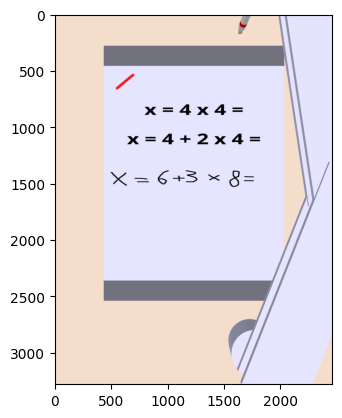

In [21]:
image = np.array(image)
image = image.astype(np.uint8)
img=np.array(abs(image),dtype=np.uint8)
img.resize([resolution[1],resolution[0],3])
img = cv2.flip(img, 1)                             # So it is not like a mirror
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(img)
plt.show()

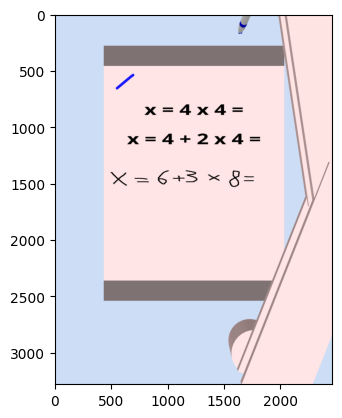

In [22]:
#CV library in Python can only work on BGR, GRAY or binarized images
img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img_BGR)
plt.show()

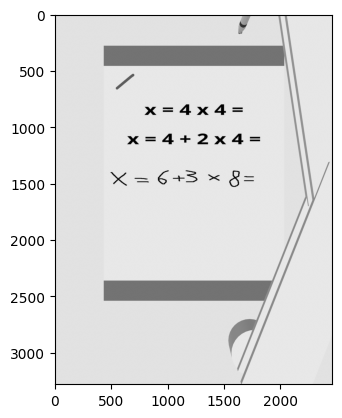

In [23]:
img_GRAY = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img_GRAY, cmap='gray', vmin=0,vmax=255)
plt.show()

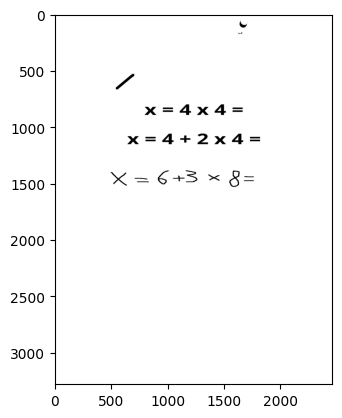

In [24]:
ret, thresh = cv2.threshold(img_GRAY,100,255,cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray', vmin=0,vmax=255)
plt.show()

In [25]:
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [26]:
result = reader.readtext(thresh, paragraph=False, allowlist="0123456789+-x*/()=", width_ths=1.0)
result
#Retorna les coordenades dels quadres de text detectats, el text detectat i la confiança
#Cada quadre de text es defineix pels quatre punts que formen el rectangle al voltant del text
#L'ordre dels quatre punts és: Top-left corner, Top-right corner, Bottom-right corner, Bottom-left corner

KeyboardInterrupt: 

In [ ]:
recognized_texts = [item[1] for item in result]
recognized_texts

In [ ]:
def convert_x(operacion):
    """
    Convierte las X en * si se trata de multiplicacion
    """
    operacion = operacion.replace(' ', '')  # Limpiar espacios
    nueva_operacion = []
    i = 0
    n = len(operacion)
    
    while i < n:
        if operacion[i] == 'x':
            # Caso 1: 'x=' → Es variable (ej: "x=4")
            if i + 1 < n and operacion[i+1] == '=':
                nueva_operacion.append('x=')  # Variable
                i += 1
            # Caso 2: 'x' entre números → Multiplicación (ej: "4x4")
            elif (i > 0 and operacion[i-1].isdigit()) and (i + 1 < n and operacion[i+1].isdigit()):
                nueva_operacion.append('*')  # Multiplicación
            else:
                nueva_operacion.append('x=')  # Por defecto, variable
        else:
            nueva_operacion.append(operacion[i])
        i += 1
    
    return ''.join(nueva_operacion)

expressions = []
for operacion in recognized_texts:
    expressions.append(convert_x(operacion))
expressions

In [ ]:
def filter_expressions(expressions):
    """
    Filters out everything from the strings that isn't a number or an operator (+, -, *, /).

    Parameters:
    - expressions: List of strings containing mathematical expressions.

    Returns:
    - A list of filtered expressions containing only numbers and operators.
    """
    # Define valid characters (numbers and operators)
    valid_chars = "0123456789+-*/"

    # Filter each expression
    filtered_expressions = []
    for expr in expressions:
        # Build a new string with only valid characters
        filtered_expr = ''.join(char for char in expr if char in valid_chars)
        filtered_expressions.append(filtered_expr)

    return filtered_expressions

operacions = filter_expressions(expressions)
operacions

In [ ]:
answers = []
for operacio in operacions:
    answers.append(eval(operacio))
answers

In [ ]:
#Calcular punt de partida per escriure el resultat
textbox_coordinates=[item[0] for item in result]
start_coordinates=[item[1] for item in textbox_coordinates]
start_coordinates

In [ ]:
#Calcular posicio en la escena
# X en la imatge es Y en el Coppelia i viceversa
coppelia_start_coordinates = []
# Dimensions plataforma en coppelia: 0.45 x 0.35
# Resolució imatge: 3280 x 2464
scale_factor = 0.45/3280
for point in start_coordinates:
    coppelia_start_coordinates.append([point[1]*scale_factor, point[0]*scale_factor+0.01])
print(coppelia_start_coordinates)